# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, Deep Learning (Gentle introduction using Keras), Sequential Model, Grid Search

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Oiq428Q4J1s" frameborder="0" 
allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [49]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.utils import plot_model

# Random Seed
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

## Auxiliary Functions

In [3]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [4]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


## Load Labels

In [5]:
filename="inst_labels.pl"
# Load labels
with open(filename, "rb") as f:
    labels = pickle.load( open( filename, "rb" ) )

In [6]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


## Parameters for MFCC

In [7]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Save / Load Feature Vector

In [8]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

## Train and Test Sets

In [9]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [10]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [11]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

In [12]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [13]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [14]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (450, 1, 13)
test_set shape: (450, 1, 13)
train_classes shape: (450, 1, 6)
test_classes shape: (150, 1, 6)


In [15]:
show_web("https://keras.io/getting-started/sequential-model-guide/")

In [16]:
def create_model(fc_layers=[4],
                 activation='relu',
                 optimizer='rmsprop'):
    model = Sequential()

    for i, size in enumerate(fc_layers):
        # Input Layer - includes the input_shape
        if i == 0:
            model.add(Dense(size,
                            activation=activation,
                            input_shape=(train_set.shape[1],)))
        else:
            model.add(Dense(size,
                            activation=activation))
            
    model.add(Dense(6,activation='softmax'))
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
model = KerasClassifier(build_fn=create_model,
                        epochs=50, 
                        batch_size=5,
                        verbose=0)

In [18]:
param_grid = {'fc_layers': [[12],[12,6],[6,6,6], [6]],
              'activation':['relu','tanh'],
              'optimizer':('rmsprop','adam'),
              'epochs':[100, 150],
              'batch_size':[5]}

In [19]:
grid = GridSearchCV(model,
                    param_grid=param_grid,
                    return_train_score=True,
                    cv=5)

categorical_encoded_train_classes=to_categorical(integer_encoded_train_classes)
grid_results = grid.fit(train_set,onehot_encoded_train_classes, verbose=1)

print('Parameters of the best model: ')
print(grid_results.best_params_)

Epoch 1/100
360/360 [==============================] - 0s 1ms/step - loss: 1.9862 - acc: 0.1083
Epoch 2/100
360/360 [==============================] - 0s 556us/step - loss: 1.7158 - acc: 0.2472
Epoch 3/100
360/360 [==============================] - 0s 509us/step - loss: 1.5112 - acc: 0.4556
Epoch 4/100
360/360 [==============================] - 0s 540us/step - loss: 1.3293 - acc: 0.5667
Epoch 5/100
360/360 [==============================] - 0s 565us/step - loss: 1.1678 - acc: 0.6306
Epoch 6/100
360/360 [==============================] - 0s 536us/step - loss: 1.0299 - acc: 0.6972
Epoch 7/100
360/360 [==============================] - 0s 553us/step - loss: 0.9122 - acc: 0.7528
Epoch 8/100
360/360 [==============================] - 0s 545us/step - loss: 0.8106 - acc: 0.7889
Epoch 9/100
360/360 [==============================] - 0s 539us/step - loss: 0.7250 - acc: 0.8056
Epoch 10/100
360/360 [==============================] - 0s 519us/step - loss: 0.6481 - acc: 0.8444
Epoch 11/100
360/360 

In [20]:
# summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975556 using {'activation': 'relu', 'batch_size': 5, 'epochs': 150, 'fc_layers': [12], 'optimizer': 'adam'}
0.962222 (0.024944) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [12], 'optimizer': 'rmsprop'}
0.955556 (0.019876) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [12], 'optimizer': 'adam'}
0.951111 (0.019373) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [12, 6], 'optimizer': 'rmsprop'}
0.964444 (0.014741) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [12, 6], 'optimizer': 'adam'}
0.928889 (0.015072) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [6, 6, 6], 'optimizer': 'rmsprop'}
0.935556 (0.025724) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [6, 6, 6], 'optimizer': 'adam'}
0.948889 (0.032660) with: {'activation': 'relu', 'batch_size': 5, 'epochs': 100, 'fc_layers': [6], 'optimizer': 'rmsprop'}
0.935556 (

In [21]:
best_model=create_model(fc_layers=[12],activation='relu', optimizer='adam')

In [24]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 150    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = best_model.fit(train_set, onehot_encoded_train_classes, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set,onehot_encoded_test_classes))

Train on 450 samples, validate on 150 samples
Epoch 1/150
450/450 [==============================] - 27s 61ms/step - loss: 2.0671 - acc: 0.1089 - val_loss: 1.9346 - val_acc: 0.1067
Epoch 2/150
450/450 [==============================] - 1s 1ms/step - loss: 1.7919 - acc: 0.1889 - val_loss: 1.7274 - val_acc: 0.3267
Epoch 3/150
450/450 [==============================] - 1s 2ms/step - loss: 1.5766 - acc: 0.3911 - val_loss: 1.5366 - val_acc: 0.5067
Epoch 4/150
450/450 [==============================] - 1s 1ms/step - loss: 1.3806 - acc: 0.5756 - val_loss: 1.3680 - val_acc: 0.5933
Epoch 5/150
450/450 [==============================] - 1s 1ms/step - loss: 1.2149 - acc: 0.6511 - val_loss: 1.2225 - val_acc: 0.6400
Epoch 6/150
450/450 [==============================] - 1s 1ms/step - loss: 1.0775 - acc: 0.6689 - val_loss: 1.0959 - val_acc: 0.6600
Epoch 7/150
450/450 [==============================] - 1s 1ms/step - loss: 0.9627 - acc: 0.7133 - val_loss: 0.9860 - val_acc: 0.6867
Epoch 8/150
450/450 [

In [25]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

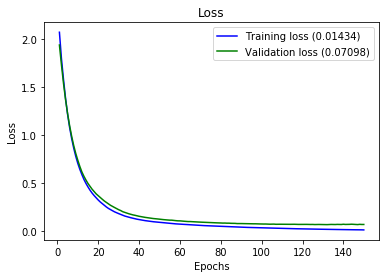

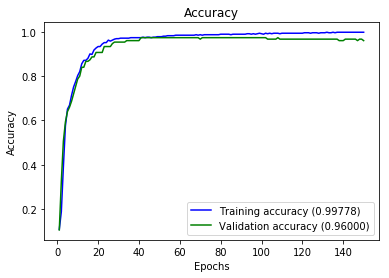

In [26]:
plot_history(hist)

In [28]:
# Predict
predictions = best_model.predict(test_set)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=1)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

In [31]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predictions_int,normalize=True), accuracy_score(test_classes, predictions_int,normalize=False) )
print("Number of samples:",test_classes.shape[0])

print(classification_report(test_classes, predictions_int))

Recall:  [0.96 1.   1.   0.96 0.92 0.92]
Precision:  [1.         0.96153846 1.         0.96       0.92       0.92      ]
F1-Score:  [0.97959184 0.98039216 1.         0.96       0.92       0.92      ]
Accuracy: 0.96  , 144
Number of samples: 150
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25
           2       1.00      1.00      1.00        25
           3       0.96      0.96      0.96        25
           4       0.92      0.92      0.92        25
           5       0.92      0.92      0.92        25

   micro avg       0.96      0.96      0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predictions_int)
np.set_printoptions(precision=2)

In [40]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

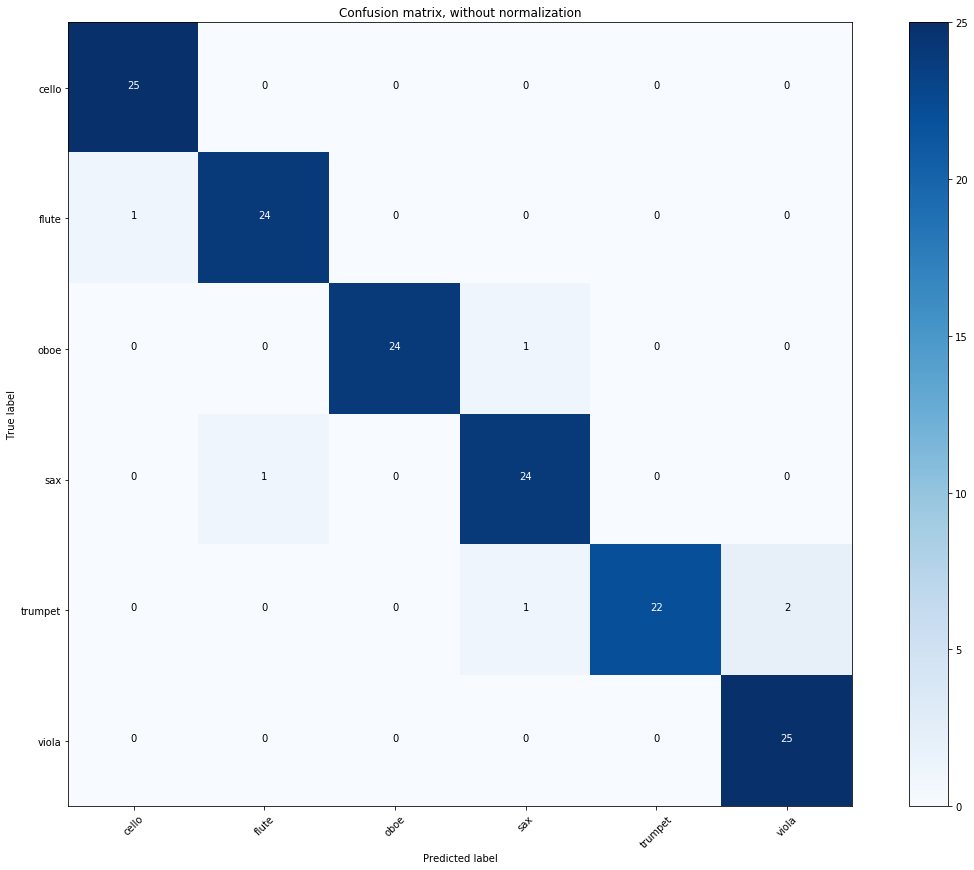

In [41]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [42]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [43]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['oboe' 'flute' 'sax' 'trumpet' 'trumpet' 'trumpet']
['sax' 'cello' 'flute' 'viola' 'sax' 'viola']
['./audio/london_phill_dataset_multi/oboe/oboe_Ds6_05_fortissimo_normal.mp3'
 './audio/london_phill_dataset_multi/flute/flute_Gs5_025_forte_normal.mp3'
 './audio/london_phill_dataset_multi/sax/saxophone_A3_15_fortissimo_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_forte_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_15_pianissimo_normal.mp3']


In [44]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_443 (Dense)            (None, 12)                168       
_________________________________________________________________
dense_444 (Dense)            (None, 6)                 78        
Total params: 246
Trainable params: 246
Non-trainable params: 0
_________________________________________________________________
